scaled_df 생성

In [1]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 판다스 출력 결과를 소수점 둘째 자리 까지로 제한
pd.options.display.float_format = '{:,.2f}'.format

# 고객 번호(customer_id), 총 구매 수량(total_buy_cnt), 총 구매 금액(total_price)
sales_df = pd.read_csv('data/sales_data.csv', index_col=['customer_id'])
sales_df

,total_buy_cnt,total_price
customer_id,,
12395,99,430250
12427,98,566410
12431,122,849900
12433,625,1180950
12471,10,97750
...,...,...
18144,30,90750
18168,243,1533530
18225,1,91430


<Axes: xlabel='total_buy_cnt', ylabel='total_price'>

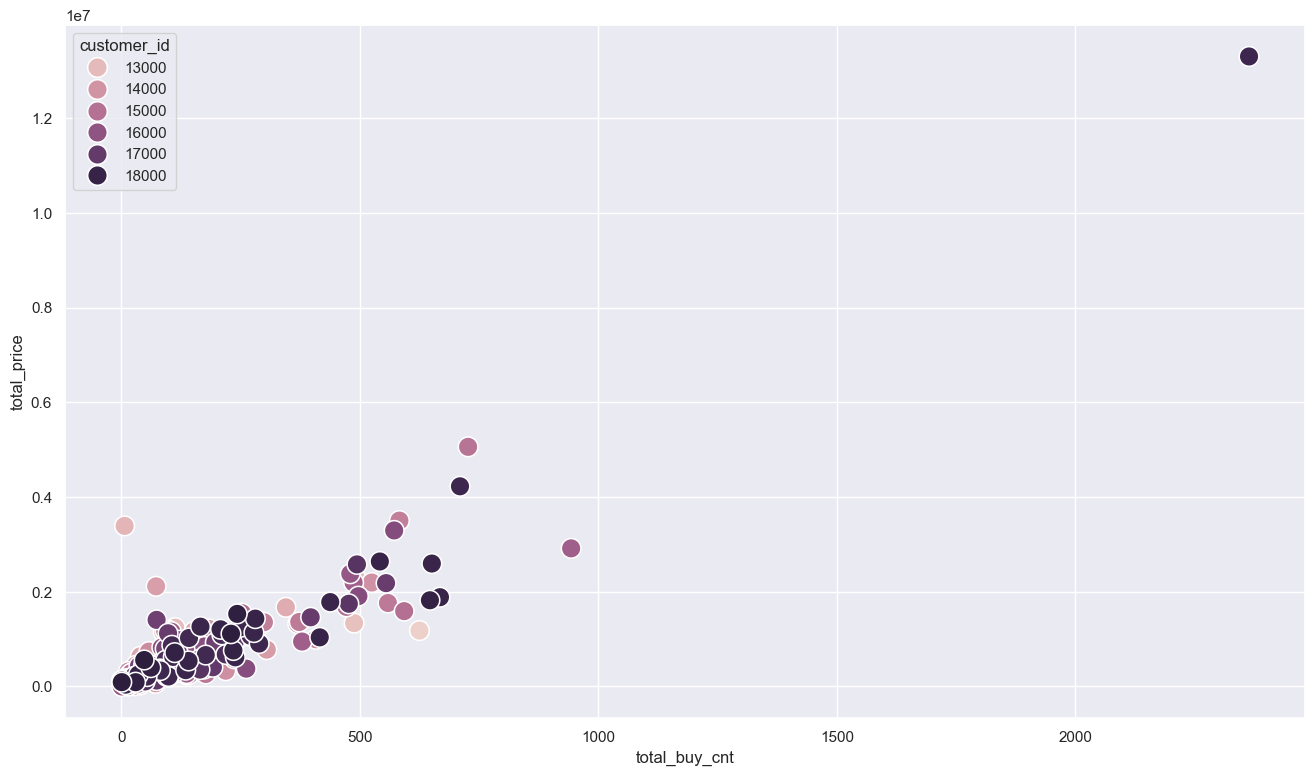

In [3]:
# 이상치 제거
import seaborn as sns
sns.set(style = "darkgrid", rc={"figure.figsize": (16,9)})
sns.scatterplot(x="total_buy_cnt", y="total_price", data=sales_df, hue="customer_id", s=200)

In [4]:
def get_outliers_mask(df):
        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        
        IQR = Q3 - Q1
        
        range_min = Q1 - (IQR * 1.5)
        range_max = Q3 + (IQR * 1.5)
        
        outlier_per_column = (df < range_min)|(df > range_max)
        is_outlier = outlier_per_column.any(axis=1)
        
        return is_outlier

In [ ]:
outlier_idx_cust_df = get_outliers_mask(sales_df)

sales_df = sales_df[~outlier_idx_cust_df]

sns.scatterplot(x="total_buy_cnt", y="total_price", data=sales_df,  palette='bright', s=200)

In [6]:
# 정규화
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_df = scaler.fit_transform(sales_df)
scaled_df

array([[-0.05320755, -0.15182767],
       [-0.06534923,  0.20642674],
       [ 0.22605112,  0.95232527],
       [-1.13381718, -1.0266778 ],
       [-0.18676604,  0.21255727],
       [-0.93955028, -1.0462797 ],
       [ 0.35960962,  0.38931646],
       [-1.09739214, -0.68021084],
       [ 0.18962608,  0.05884676],
       [-0.0167825 ,  0.74570277],
       [-0.23533277, -0.59364672],
       [-0.50244975,  0.12744027],
       [ 1.1488189 ,  1.6968293 ],
       [-0.47816639,  0.0309568 ],
       [-1.04882541, -1.0054709 ],
       [-0.55101648, -0.70917956],
       [-1.03668373, -0.77401056],
       [-0.81813347, -0.12188543],
       [ 0.97883536,  0.70647265],
       [-0.91526692, -1.14313153],
       [-0.23533277, -0.13240995],
       [-0.18676604,  1.7420584 ],
       [-0.150341  , -0.15664264],
       [ 0.20176776,  0.23918429],
       [ 0.11677599,  1.98570087],
       [-0.76956674, -1.19546467],
       [-0.97597532, -0.90106774],
       [-1.02454205, -0.95403235],
       [-0.07749091,

In [7]:
# 스케일링된 데이터를 데이터프레임으로 변환
scaled_df = pd.DataFrame(scaled_df, columns=sales_df.columns)
# 저장할 경로 지정
save_path = 'data/scaled_df.csv'
# 스케일링된 데이터프레임을 CSV 파일로 저장
scaled_df.to_csv(save_path, index=False)
# 결과 출력 (확인용)
print(f"CSV 파일이 다음 경로에 저장되었습니다: {save_path}")

CSV 파일이 다음 경로에 저장되었습니다: data/scaled_df.csv


## 계층 기반 클러스터링
기본적으로 유사한 데이터를 묶은 클러스터들을 층으로 쌓아가며 클러스터링하는 방식
### 계층적 클러스터링에는 linkage() 함수가 사용

In [8]:
# 모델 학습
# 파라미터로 데이터와 어떠한 거리 메소드를 사용할지 지정
# 거리 : ward method
model = linkage(scaled_df, 'ward')

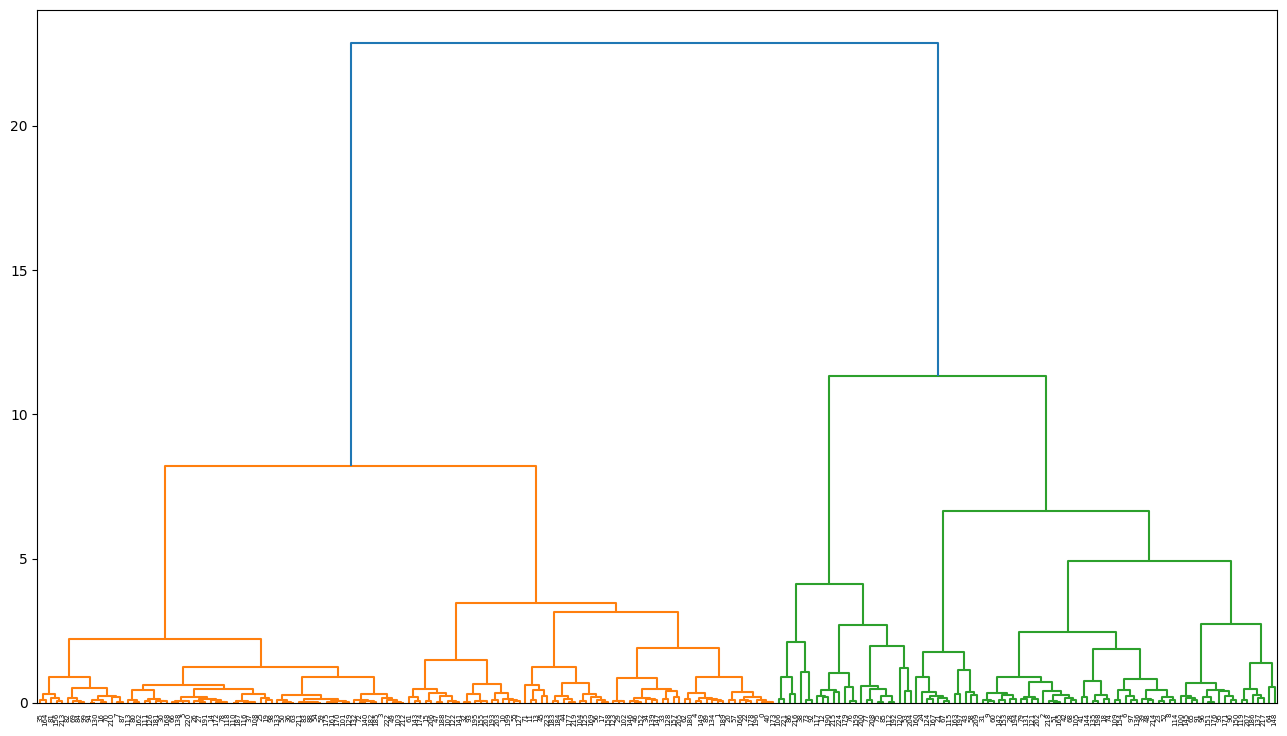

In [9]:
# 덴드로그램 시각화
labelList = scaled_df.index

# 덴드로그램 사이즈와 스타일 조정
plt.figure(figsize=(16,9))
plt.style.use("default")

dendrogram(model, labels=labelList)
plt.show()

In [10]:
# 클러스터를 5개로 나눠 보고, 각 클러스터별로 고객이 몇 명씩 속해 있는지 확인
cluster_num = 5

# 고객별 클러스터 라벨 구하기
# cut_tree는 계층적 군집 분석에서 사용하는 함수
scaled_df['label'] = cut_tree(model, cluster_num)

pd.DataFrame(scaled_df['label'].value_counts())

,count
label,
0,67
2,67
1,54
3,25
4,12


<Axes: xlabel='total_price', ylabel='total_buy_cnt'>

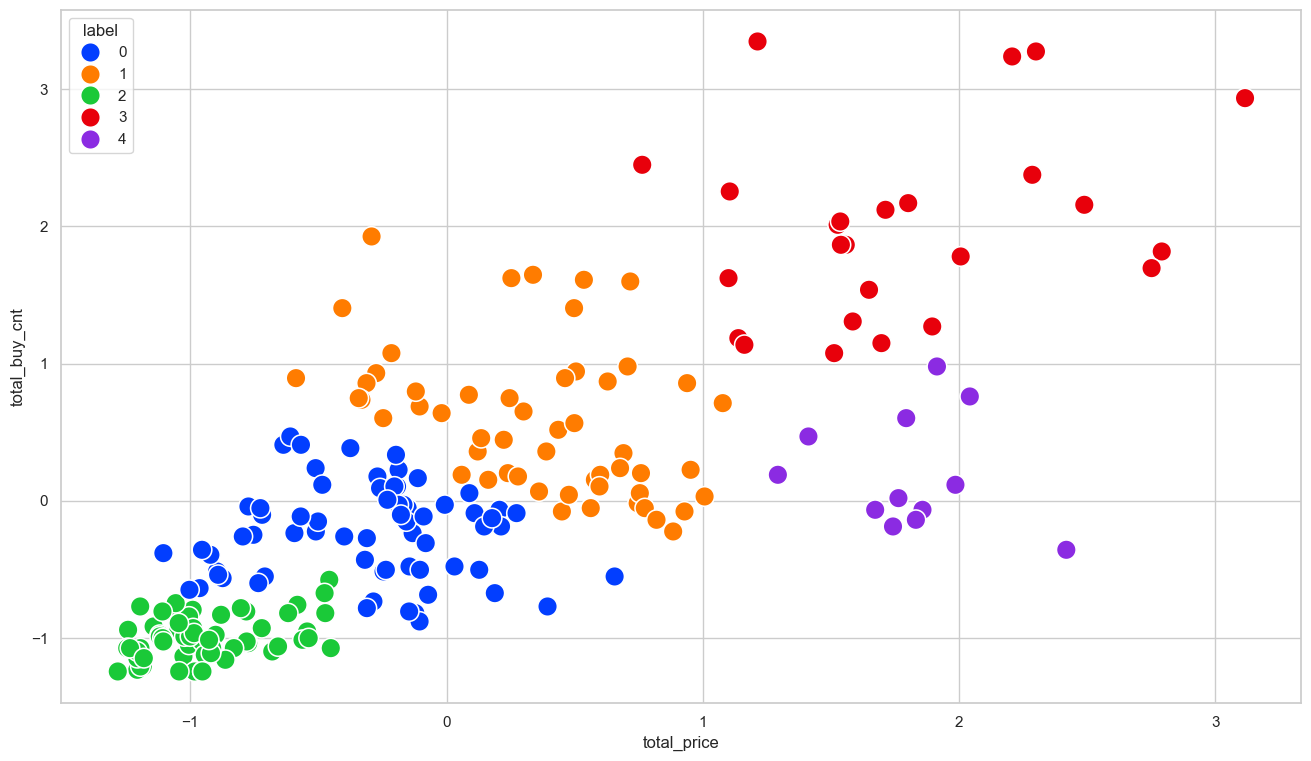

In [11]:
# style 종류 white, dark, whitegrid, darkgrid, ticks
sns.set(style="whitegrid",
        rc={"figure.figsize": (16,9)})

# 계층형 클러스터링
sns.scatterplot(x=scaled_df['total_price'], y=scaled_df['total_buy_cnt'], hue=scaled_df['label'], s=200, palette='bright')

## 계층적 클러스터링 장단점

장점
1. 계층적 클러스터링의 가장 큰 장점은 모델을 학습시킬 때 클러스터의 개수를 미리 가정하지 않아도 된다
2. k-means는 사전에 정한 k 값에 따라 결과가 달라졌지만, 계층적 클러스터링은 클러스터의 개수에 상관 없이 모델을 학습

단점
1. 모든 데이터끼리의 거리를 반복해서 계산해야 하기 때문에 많은 연산이 필요
2. 학습 속도가 느리고 대용량 데이터에 적용이 어렵다

## 밀도 기반 클러스터링
## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
## 밀도 기반 클러스터링 방법
밀도가 높은 부분을 같은 클러스터로 묶어 나가는 방식

어떤 데이터가 특정 클러스터에 속할 경우, 클러스터 내의 다른 데이터들과 가까운 위치에 있어야 한다.

임의로 지정하는 값
1. 얼마나 가까운 위치에 데이터가 있어야 하는지 나타내는 반경(Radius)
2. 반경 내에 얼마나 많은 데이터가 있어야 하는지를 나타내는 최소 데이터 개수(Minimum Points)

k-means는 이상치가 Centroid 위치에 관여하면서 결과에 영향을 끼쳤지만 
DBSCAN은 기준에 포함되지 못하는 데이터를 제외하기 때문에 이상치에 강건(Robust)한 방법

반면, 고차원 데이터일수록 데이터 간 밀도를 계산하기 어렵고, 연산이 많아져 학습 속도가 느려질 수 있다는 단점

<Axes: xlabel='0', ylabel='1'>

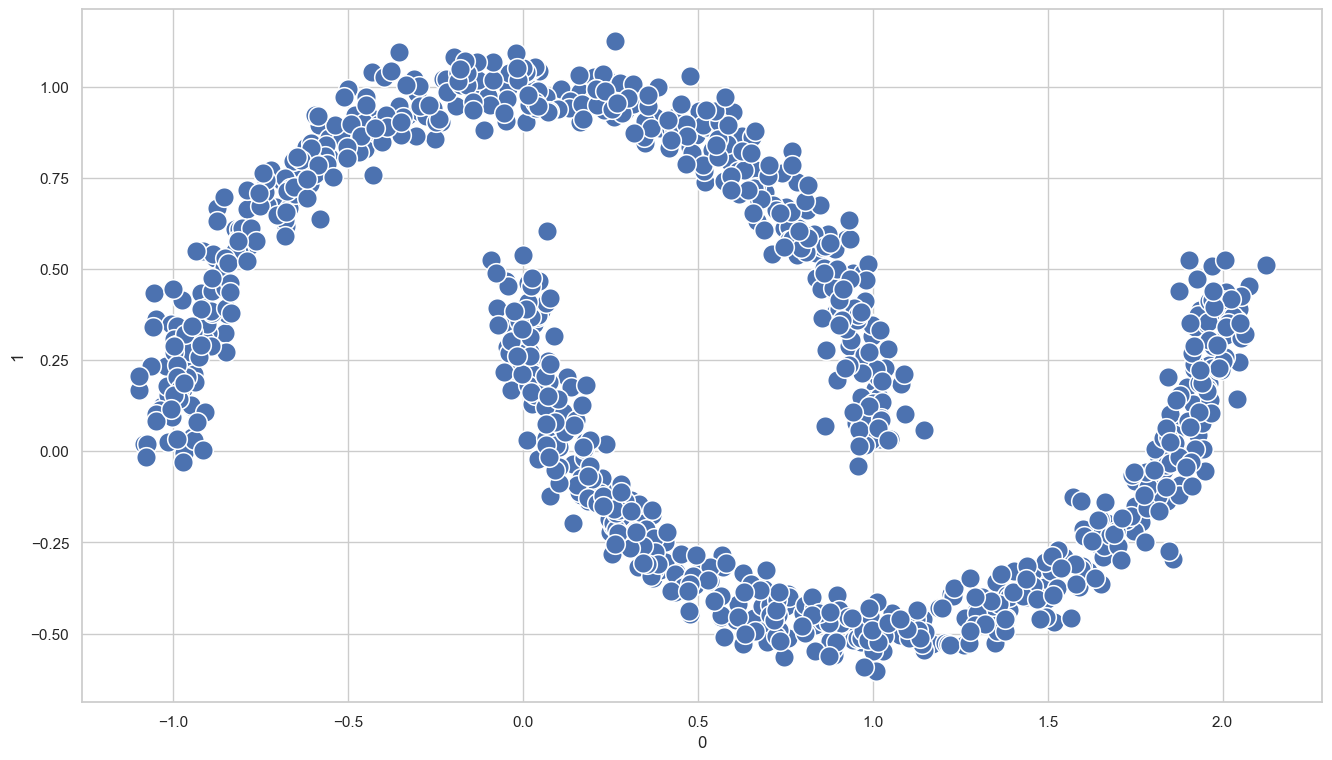

In [12]:
from sklearn.datasets import make_moons
import numpy as np

# 샘플 수 선정
n_samples = 1000

# 난수 시드 고정
np.random.seed(3)

# make_moons 함수로 데이터 생성
X, y = make_moons(n_samples, noise=.05) # noise: 잡음의 크기. 0이면 정확한 반원을 이룸
df = pd.DataFrame(X)

# 시각화
plt.figure(figsize=(16,9))
sns.scatterplot(x=df[0], y=df[1], markers='o', s=200)

# 이 데이터를 k-means와 DBSCAN 각각으로 클러스터링 해보고 결과를 비교

ValueError: Per-column arrays must each be 1-dimensional

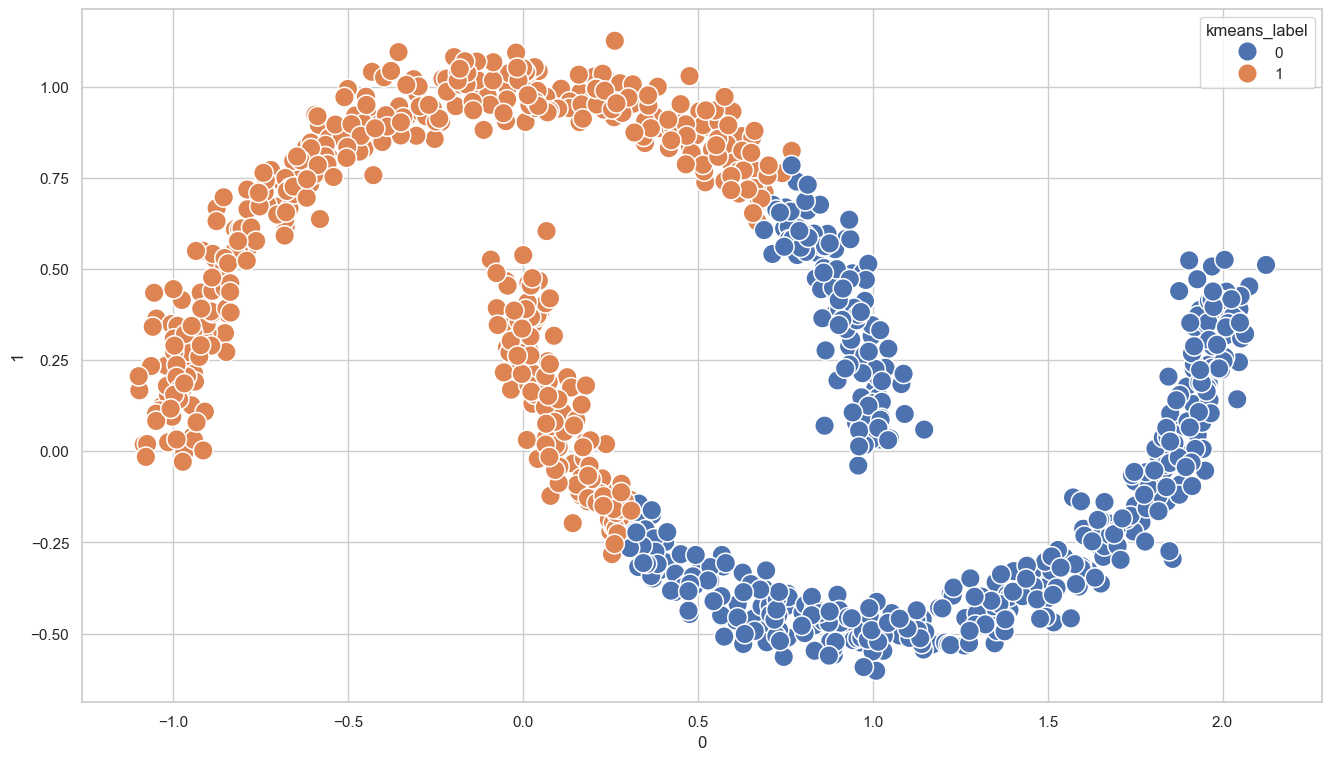

In [13]:
# k-means 모델 학습
from sklearn.cluster import KMeans

model = KMeans(n_clusters=2, random_state=123)
model.fit(df)

# 클러스터 라벨링
df['kmeans_label'] = model.predict(df)

# 각 군집의 중심점
centers = model.cluster_centers_

# 클러스터링 시각화
plt.figure(figsize=(16,9))
sns.scatterplot(x=df[0], y=df[1], hue=df['kmeans_label'], s=200)
sns.scatterplot(x=centers[:,0], y=centers[:1], s=200)

In [ ]:
# DBSCAN 클러스터링
df = df.drop(columns=['kmeans_label'], axis=1)

# 임의로 최소 데이터 개수는 5, 반경은 0.1
# DBSCAN에서 클러스터링 된 결과를 확인할 때에는 predict() 대신 labels_ 속성을 사용

from sklearn.cluster import DBSCAN

eps = 0.1 # 반경
min_samples = 5 # 최소 데이터개수

# DBSCAN 모델 학습
model = DBSCAN(eps=eps, min_samples=min_samples)
model.fit(df)
df['dbscan_label'] = model.labels_

# 시각화
plt.figure(figsize=(16,9))
sns.scatterplot(x=df[0], y=df[1], hue=df['dbscan_label'], s=200)

## GMM (Gaussian Mixture Model)
## 분포 기반 클러스터링 
각 클러스터에 포함된 데이터들이 정규분포를 따른다고 가정했을 때, 
특정 데이터가 포함될 확률이 가장 높은 분포의 클러스터가 무엇인지를 찾아 클러스터를 나누는 방법

장점
데이터가 타원형으로 흩어져 있다면 중심(평균)과 분산의 값을 갖는 형태이기 때문에 GMM이 적합 (원형은 k-means)

단점
1. k-means와 비슷하게 사전에 클러스터 개수를 임의로 설정
2. 특정 분포에 할당되는 데이터 수가 적으면 모수 추정이 잘 이뤄지지 않기 때문에, 충분히 많은 수의 데이터가 있지 않으면 적용하기 어렵다
3. 범주형 데이터는 다룰 수 없다

<Axes: xlabel='0', ylabel='1'>

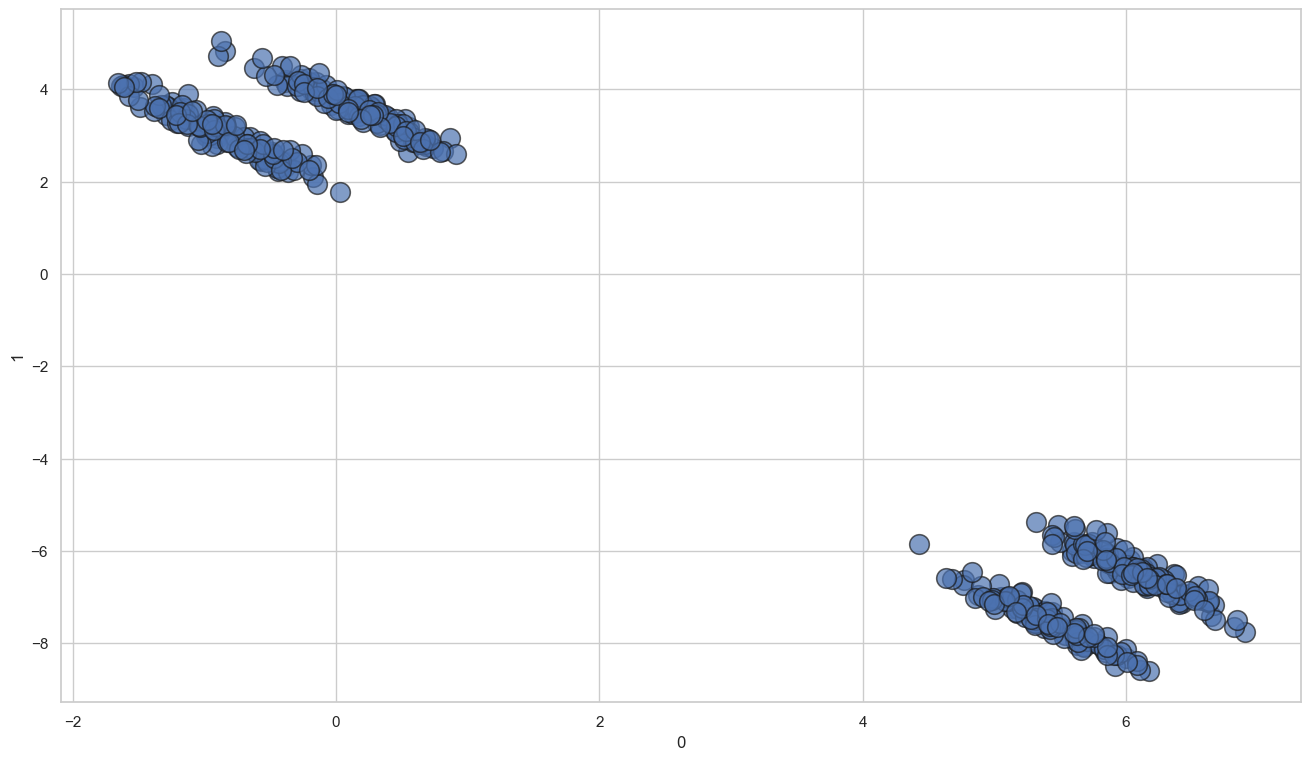

In [14]:
from sklearn.datasets import make_blobs

n_samples = 500 # 샘플데이터 개수
center = 4 # 클러스터 개수
cluster_std = 0.5 # 클러스터 내 표준편차
random_state = 13 # 샘플 데이터 고정

data, clusters = make_blobs(n_samples=n_samples, centers=center, cluster_std=cluster_std, random_state=random_state)

# 데이터 타원형으로 만들기
tf = [[0.6, -0.6], [-0.4, 0.8]]
data_tf = data@tf # @ : 행렬의 곱을 나타냄
df = pd.DataFrame(data_tf)

# 시각화
sns.scatterplot(x=df[0], y=df[1], alpha= 0.7, edgecolors='k', s=200)

<Axes: xlabel='0', ylabel='1'>

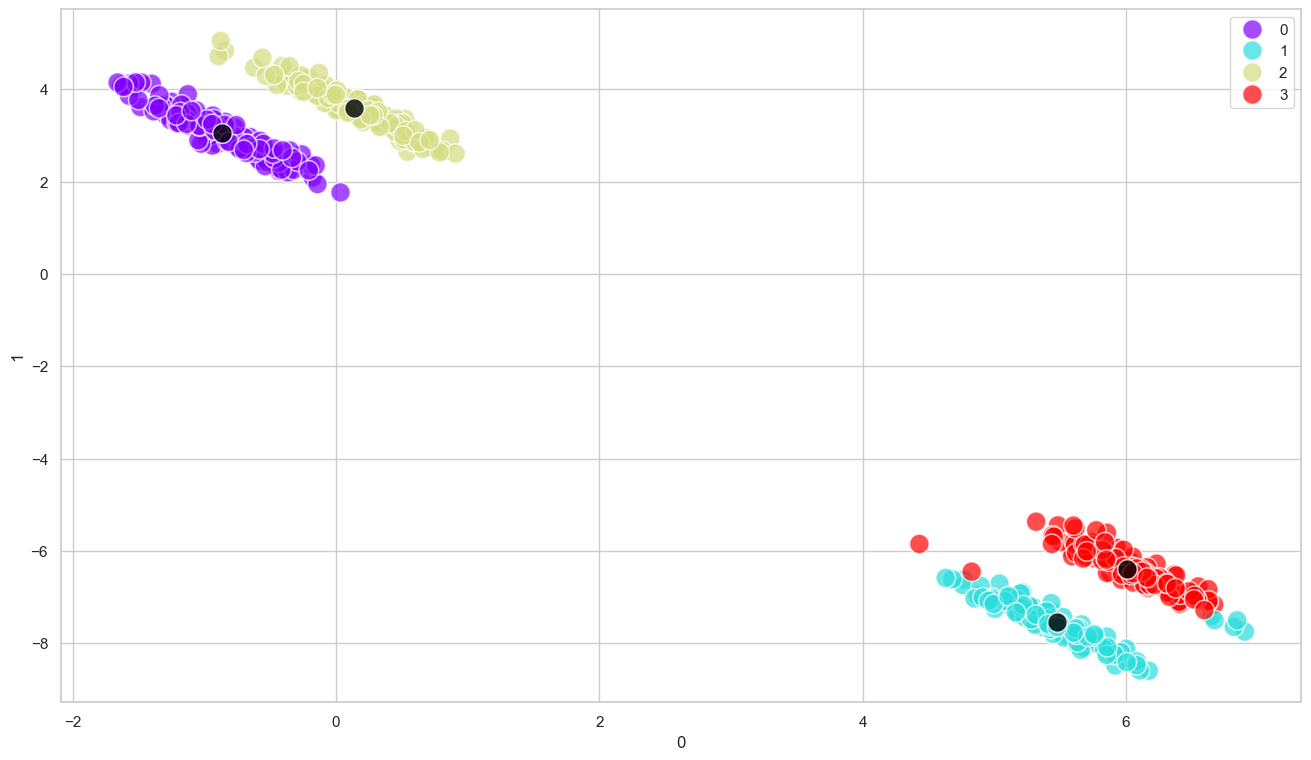

In [15]:
# k-means 학습
model = KMeans(n_clusters=4, random_state=123)
model.fit(df)
df['kmeans_label'] = model.predict(df)
centers = model.cluster_centers_ # 각 클러스터의 Centorid

# 시각화
sns.scatterplot(x=df[0], y=df[1], hue=df['kmeans_label'], palette='rainbow', alpha=0.7, s=200)
sns.scatterplot(x=centers[:,0], y=centers[:,1], color='black', alpha=0.8, s=200)

In [16]:
df

,0,1,kmeans_label
0,-0.65,2.96,0
1,5.19,-7.18,1
2,6.23,-6.28,3
3,-0.49,2.60,0
4,6.13,-6.37,3
...,...,...,...
495,6.16,-6.58,3
496,6.60,-7.28,3
497,5.70,-6.01,3
498,5.17,-7.33,1


타원형 데이터는 k-means로 잘 되지 않음

In [17]:
# df['kmeans_label']를 제거
df = df.drop(columns=['kmeans_label'], axis=1)
df

,0,1
0,-0.65,2.96
1,5.19,-7.18
2,6.23,-6.28
3,-0.49,2.60
4,6.13,-6.37
...,...,...
495,6.16,-6.58
496,6.60,-7.28
497,5.70,-6.01
498,5.17,-7.33


<Axes: xlabel='0', ylabel='1'>

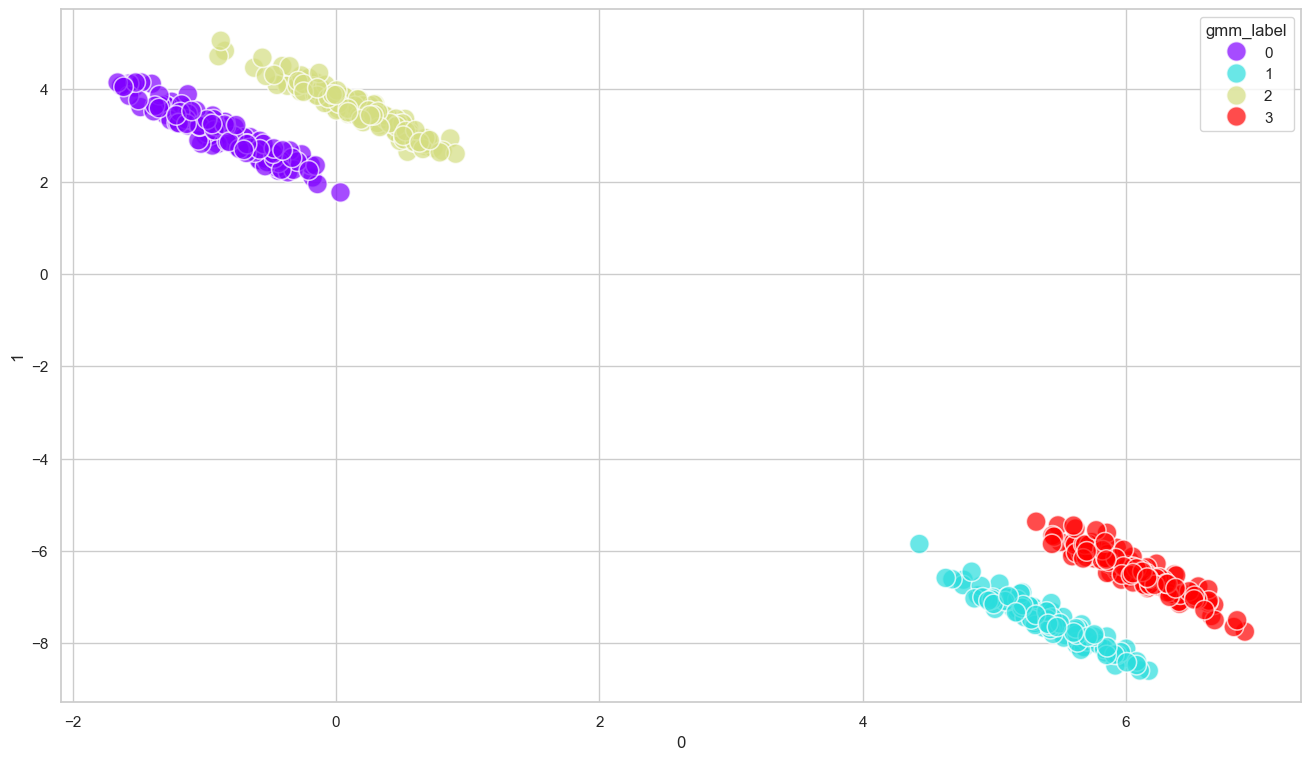

In [18]:
from sklearn.mixture import GaussianMixture

n_components = 4 # 분포 개수
random_state = 10 # 모델 고정

model = GaussianMixture(n_components=n_components, random_state=random_state)

## GMM 모델 학습
model.fit(df)
df['gmm_label'] = model.predict(df)

# 시각화
sns.scatterplot(x=df[0], y=df[1], hue=df['gmm_label'], palette='rainbow', alpha=0.7, s=200)